In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow import keras
%matplotlib inline
# The dimensions of our input image
img_width = 416
img_height = 416
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.


In [2]:
model_location='/home/craig/Documents/YOLO-3-OpenCV/yolo3_tf/yolov3_model'
yolo3_model=keras.models.load_model(model_location, compile=False)

2022-05-20 13:46:11.029339: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-20 13:46:11.029537: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 13:46:11.030583: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
yolo3_model.compile(
    optimizer=keras.optimizers.RMSprop()  # Optimizer,
)

In [4]:
yolo3_model.summary()
yolo3_model.layers

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv_6 (TFOpLambda)  (None, 416, 416, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf.math.truediv_6[0][0]          
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
____________________________________________________________________________________________

In [7]:
l=yolo3_model.get_layer('conv_0').get_weights()[0][0][0][0]
len(l)
print(l)

[-0.07398386 -0.16561401  0.09200411 -0.5134506  -0.43619505  0.14501905
  0.21514662 -0.00296055  0.5838404  -0.04998723 -0.55366224  0.4685391
 -0.0897575  -0.28680146 -0.17927131  0.03548688 -0.42147002 -0.25997573
  0.07504789  0.4739453   0.07131134 -0.01735255 -0.14715247  0.5200021
 -0.08380964  0.18117398 -0.17634144 -0.01558126  0.17390238 -0.34230056
 -0.03375314 -0.3877996 ]


In [17]:
#weights= yolo3_model.get_layer("conv_0").weights
#print(weights[0])

In [68]:
layer_name = "conv_2"
# Set up a model that returns the activation values for our target layer
layer = yolo3_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=yolo3_model.inputs, outputs=layer.output)

In [69]:
feature_extractor.summary()
#help(feature_extractor)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 416, 416, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 416, 416, 32)      864       
_________________________________________________________________
bnorm_0 (BatchNormalization) (None, 416, 416, 32)      128       
_________________________________________________________________
leaky_0 (LeakyReLU)          (None, 416, 416, 32)      0         
_________________________________________________________________
zero_padding2d_30 (ZeroPaddi (None, 417, 417, 32)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 208, 208, 64)      1843

In [70]:
img = tf.ones( shape=(1,img_width,img_height, 3))
#eature_extractor.......

In [71]:
#activation = feature_extractor(img)
activation[:, 2:-2, 2:-2, 1]
compute_loss(img,1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2931518>

In [72]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [73]:
#@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
        #print(loss)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    #print('grad')
    #print(grads)
    img += learning_rate * grads
    #print(img[0,1,1,1])
    return loss, img

In [100]:
img = tf.random.uniform(shape=(1, img_width, img_height, 3),minval=0,maxval=255)
print(img[0,1,1,1])

tf.Tensor(110.957146, shape=(), dtype=float32)


In [85]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform(shape=[1, img_width, img_height, 3],minval=0,maxval=255)
    #print(img[0,1,1,2])
    #img = tf.random.uniform(shape=[1, img_width, img_height, 3])
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    #return (img - 0.5) * 0.25
    return (img )


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 300
    learning_rate = 50.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)
        print(loss)
        #print(img[0,135,135,2])
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-10
    #img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [86]:
loss, img = visualize_filter(2)
keras.preprocessing.image.save_img("/home/craig/Documents/YOLO-3-OpenCV/yolo3_tf/0.png", img)

tf.Tensor(-2.526328, shape=(), dtype=float32)
tf.Tensor(-2.5163927, shape=(), dtype=float32)
tf.Tensor(-2.50647, shape=(), dtype=float32)
tf.Tensor(-2.49656, shape=(), dtype=float32)
tf.Tensor(-2.4866648, shape=(), dtype=float32)
tf.Tensor(-2.4767816, shape=(), dtype=float32)
tf.Tensor(-2.4669092, shape=(), dtype=float32)
tf.Tensor(-2.4570525, shape=(), dtype=float32)
tf.Tensor(-2.4472086, shape=(), dtype=float32)
tf.Tensor(-2.4373786, shape=(), dtype=float32)
tf.Tensor(-2.4275606, shape=(), dtype=float32)
tf.Tensor(-2.417754, shape=(), dtype=float32)
tf.Tensor(-2.407962, shape=(), dtype=float32)
tf.Tensor(-2.3981826, shape=(), dtype=float32)
tf.Tensor(-2.3884144, shape=(), dtype=float32)
tf.Tensor(-2.3786623, shape=(), dtype=float32)
tf.Tensor(-2.368922, shape=(), dtype=float32)
tf.Tensor(-2.359194, shape=(), dtype=float32)
tf.Tensor(-2.3494802, shape=(), dtype=float32)
tf.Tensor(-2.339781, shape=(), dtype=float32)
tf.Tensor(-2.3300974, shape=(), dtype=float32)
tf.Tensor(-2.3204293, s

tf.Tensor(-0.98115265, shape=(), dtype=float32)
tf.Tensor(-0.9735104, shape=(), dtype=float32)
tf.Tensor(-0.9658791, shape=(), dtype=float32)
tf.Tensor(-0.95825636, shape=(), dtype=float32)
tf.Tensor(-0.9506552, shape=(), dtype=float32)
tf.Tensor(-0.94304717, shape=(), dtype=float32)
tf.Tensor(-0.9354587, shape=(), dtype=float32)
tf.Tensor(-0.9278846, shape=(), dtype=float32)
tf.Tensor(-0.9203228, shape=(), dtype=float32)
tf.Tensor(-0.9127714, shape=(), dtype=float32)
tf.Tensor(-0.90524286, shape=(), dtype=float32)
tf.Tensor(-0.89771616, shape=(), dtype=float32)
tf.Tensor(-0.89020497, shape=(), dtype=float32)
tf.Tensor(-0.8827021, shape=(), dtype=float32)
tf.Tensor(-0.8752136, shape=(), dtype=float32)
tf.Tensor(-0.86773306, shape=(), dtype=float32)
tf.Tensor(-0.8602573, shape=(), dtype=float32)
tf.Tensor(-0.8527981, shape=(), dtype=float32)
tf.Tensor(-0.8453501, shape=(), dtype=float32)
tf.Tensor(-0.83791494, shape=(), dtype=float32)
tf.Tensor(-0.83048815, shape=(), dtype=float32)
tf.T

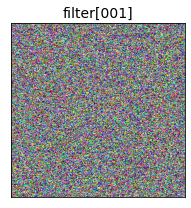

In [84]:
# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
                 
f, ax = plt.subplots(**subplot_args)
ax.imshow(img)
ax.set_title('filter[{:03d}]'.format(1), fontsize=14)
plt.tight_layout()
plt.show()